In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 1000

In [2]:
data = pd.read_csv('sales-data.csv',parse_dates=['barr_date'])

data = data[(data.region_name=="India") & (data.business_area_name=="B00 - Services") ]
display(data.head())

data.rename(columns={"barr_date":"date","revenue": "sales"}, inplace=True)
data = data[['date','sales']]
data.set_index('date', inplace=True)
data.head()

,business_area_name,region_name,barr_date,revenue
19,B00 - Services,India,2022-03-01,3020141.03
33,B00 - Services,India,2022-02-01,5345621.86
58,B00 - Services,India,2022-01-01,3732065.96
66,B00 - Services,India,2021-12-01,2696303.66
105,B00 - Services,India,2021-11-01,3347397.70


,sales
date,
2022-03-01,3020141.03
2022-02-01,5345621.86
2022-01-01,3732065.96
2021-12-01,2696303.66
2021-11-01,3347397.70


In [3]:
# Mining GDP
mining_data = pd.read_csv('mining GDP NRM regions.csv',parse_dates=['DateTime'])
mining_data['MGDP_Index'] = mining_data['Mining_GDP_BUSD'] / mining_data['Base_Mining_GDP']
mining_data = mining_data[(mining_data["Sales Area"]=="India") & (mining_data.Country=="India")]
mining_data = mining_data[['DateTime','MGDP_Index']]
mining_data.set_index('DateTime', inplace=True)
mining_data = mining_data.sort_index()
display(mining_data.head())

,MGDP_Index
DateTime,
2007-03-31,NaN
2007-06-30,NaN
2007-09-30,NaN
2007-12-31,NaN
2008-03-31,NaN


In [4]:
# Financials
ebit_data = pd.read_csv('Miners EBIT_rev_stock adp Long.csv',parse_dates=['Date'])
ebit_data['EBIT_Index'] = ebit_data['EBIT_MUSD'] / ebit_data['Ref_EBIT']
ebit_data['Revenue_Index'] = ebit_data['Revenue_MUSD'] / ebit_data['Ref_Revenue']
ebit_data = ebit_data[['Date','EBIT_Index','Revenue_Index','Trading Country']]
display(ebit_data)

,Date,EBIT_Index,Revenue_Index,Trading Country
0,2011-12-31,1.64,1.89,China
1,2012-03-31,1.16,0.70,China
2,2012-06-30,0.87,0.94,China
3,2012-09-30,1.30,0.86,China
4,2012-12-31,0.72,1.23,China
...,...,...,...,...
4407,2021-12-31,3.44,0.65,Australia
4408,2022-03-31,8.62,0.74,Australia
4409,2022-06-30,7.81,0.75,Australia
4410,2022-09-30,13.63,0.59,Australia


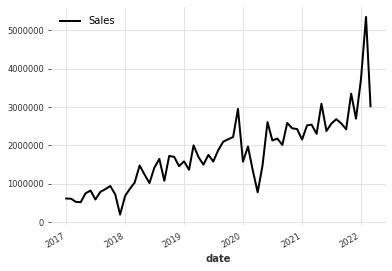

In [5]:
series_sales = TimeSeries.from_dataframe(data)

plt.ticklabel_format(style='plain')
series_sales.plot(label="Sales")
plt.legend()

In [6]:
data2 = pd.read_csv('commodity_index.csv',parse_dates=['ts_month'])

data2 = data2[(data2.ts_month>='2017-01-01')]
display(data2.head())

data2.rename(columns={"ts_month":"date","commodity_index": "values"}, inplace=True)
data3 = data2[['date','gold_index']]
data4 = data2[['date','silver_index']]
data5 = data2[['date','palladium_index']]
data6 = data2[['date','platinum_index']]

data2 = data2[['date','values']]
data2.set_index('date', inplace=True)
display(data2.head())

data3.set_index('date', inplace=True)
display(data3.head())

data4.set_index('date', inplace=True)
display(data4.head())

data5.set_index('date', inplace=True)
display(data5.head())

data6.set_index('date', inplace=True)
display(data6.head())

,ts_month,copper_index,ironore_index,lead_index,molybdenum_index,nickel_index,uranium_index,zinc_index,gold_index,platinum_index,palladium_index,silver_index,commodity_index
95,2017-01-01,0.60,0.44,0.86,0.39,0.39,0.34,1.15,0.88,0.54,0.94,0.59,0.81
96,2017-02-01,0.62,0.49,0.89,0.41,0.42,0.37,1.20,0.91,0.56,0.97,0.63,0.85
97,2017-03-01,0.61,0.48,0.88,0.43,0.40,0.37,1.17,0.90,0.54,0.98,0.62,0.83
98,2017-04-01,0.60,0.39,0.86,0.50,0.38,0.34,1.11,0.93,0.54,1.01,0.63,0.81
99,2017-05-01,0.59,0.34,0.83,0.50,0.36,0.32,1.09,0.92,0.52,1.00,0.59,0.80


,values
date,
2017-01-01,0.81
2017-02-01,0.85
2017-03-01,0.83
2017-04-01,0.81
2017-05-01,0.80


,gold_index
date,
2017-01-01,0.88
2017-02-01,0.91
2017-03-01,0.90
2017-04-01,0.93
2017-05-01,0.92


,silver_index
date,
2017-01-01,0.59
2017-02-01,0.63
2017-03-01,0.62
2017-04-01,0.63
2017-05-01,0.59


,palladium_index
date,
2017-01-01,0.94
2017-02-01,0.97
2017-03-01,0.98
2017-04-01,1.01
2017-05-01,1.00


,platinum_index
date,
2017-01-01,0.54
2017-02-01,0.56
2017-03-01,0.54
2017-04-01,0.54
2017-05-01,0.52


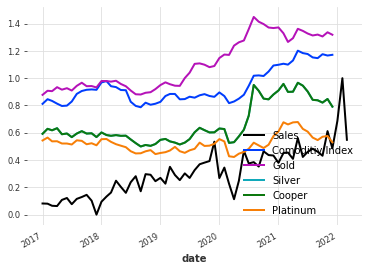

In [23]:
series_commodities = TimeSeries.from_dataframe(data2)
series_gold = TimeSeries.from_dataframe(data3)
series_silver = TimeSeries.from_dataframe(data4)
series_cooper = TimeSeries.from_dataframe(data5)
series_platinum = TimeSeries.from_dataframe(data6)

scaler_sales, scaler_commodities, scaler_gold, scaler_silver, scaler_cooper, scaler_platinum = Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler()
series_sales_scaled = scaler_sales.fit_transform(series_sales)
series_commodities_scaled = scaler_commodities.fit_transform(series_commodities)
series_gold_scaled = scaler_gold.fit_transform(series_gold)
series_silver_scaled = scaler_silver.fit_transform(series_silver)
series_cooper_scaled = scaler_cooper.fit_transform(series_cooper)
series_platinum_scaled = scaler_platinum.fit_transform(series_platinum)

plt.ticklabel_format(style='plain')
series_sales_scaled.plot(label="Sales")
series_commodities.plot(label="Comoditiy Index")
series_gold.plot(label="Gold")
series_silver.plot(label="Silver")
series_silver.plot(label="Cooper")
series_platinum.plot(label="Platinum")
plt.legend()


#series_miningGDP = TimeSeries.from_dataframe(mining_data)
#series_miningGDP.plot(label="MGDP_Index")
#plt.legend()

#scaler_miningGDP = Scaler()
#series_miningGDP_scaled = scaler_miningGDP.fit_transform(series_miningGDP)

In [21]:
train_sales, val_sales = series_sales_scaled[:-12], series_sales_scaled[-12:]
train_commodities, val_commodities = series_commodities_scaled[:-12], series_commodities_scaled[-12:]
train_gold, val_gold = series_gold_scaled[:-12], series_gold_scaled[-12:]
train_silver, val_silver = series_silver_scaled[:-12], series_silver_scaled[-12:]
train_cooper, val_cooper = series_cooper_scaled[:-12], series_cooper_scaled[-12:]
train_platinum, val_platinum = series_platinum_scaled[:-12], series_platinum_scaled[-12:]
#train_miningGDP, val_miningGDP = series_miningGDP_scaled[:-12], series_miningGDP_scaled[-12:]

In [35]:
model_sales = NBEATSModel(input_chunk_length=12, output_chunk_length=12, n_epochs=100, random_state=0)
model_sales.fit([train_sales,train_commodities,train_gold,train_silver,train_cooper],verbose=True)

[2022-05-09 13:02:27,600] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 140 samples.
[2022-05-09 13:02:27,600] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 140 samples.
2022-05-09 13:02:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 140 samples.
[2022-05-09 13:02:27,645] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-09 13:02:27,645] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-05-09 13:02:27 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-05-09 13:02:27,646] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightnin

Training: 0it [00:00, ?it/s]

In [36]:
pred = model_sales.predict(n=24, series=train_sales)

Predicting: 5it [00:00, ?it/s]

MAPE = 52.67%


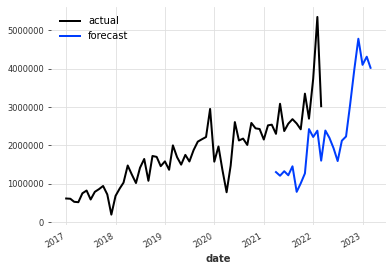

In [37]:
original = scaler_sales.inverse_transform(series_sales_scaled)
predicted = scaler_sales.inverse_transform(pred)

plt.ticklabel_format(style='plain')
original.plot(label="actual")
predicted.plot(label="forecast")
plt.legend()

print("MAPE = {:.2f}%".format(mape(series_sales_scaled, pred)))

In [38]:
xxx = predicted['sales'].pd_dataframe()
xxx

component,sales
date,
2021-04-01,1303899.21
2021-05-01,1209772.72
2021-06-01,1326715.24
2021-07-01,1221361.89
2021-08-01,1454793.12
2021-09-01,789664.22
2021-10-01,1011191.83
2021-11-01,1270078.13
2021-12-01,2424294.28
